## Evaluation of various Hyperbolics Embedding via Reconstruction Task

In [1]:
import numpy as np
import torch
from itertools import combinations
from numpy.linalg import norm
from IPython.display import clear_output
import pandas as pd

In [2]:
import pickle

def save_data_with_pickle(relative_path, data):
    """ Save data using pickle (serialize) """

    with open(relative_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_data_with_pickle(relative_path):
    """ Load data using pickle (deserialize) """

    with open(relative_path, 'rb') as handle:
        return pickle.load(handle)

In [3]:
dic = load_data_with_pickle('./dic')
inv_dic = load_data_with_pickle('./inv_dic')

#### Load Embedding

##### Nickel Poincarè

In [7]:
nickel_poincare = torch.load('/datahdd/vmanuel/hyperbolic_embedding_algorithms/nickel/poincare-embeddings/dbpedia/models/dbpedia.pth')
vectors = nickel_poincare['model']['lt.weight']
vectors = [v.numpy() for v in vectors]

nickel_poincare_emb = {k: v for k, v in zip(nickel_poincare['objects'], vectors)}

In [4]:
with open('/datahdd/vmanuel/hyperbolic_embedding_algorithms/HyperE-Stanford/hyperbolics/dbpedia.r2.emb', 'r') as inp:
    lines = inp.readlines()
    lines = lines[1:]
    lines = [l.replace('\n','') for l in lines]
    tau = float(lines[0].split(',')[-1])
    stanford_emb = {inv_dic[l.split(',')[0]]: np.array(l.split(',')[1:-1]).astype('float64') for l in lines}    

In [8]:
types = list(nickel_poincare_emb.keys())

In [9]:
tau

4.951051289713895

### Distances

In [14]:
def hyperbolic_distance(v1, v2):
    return np.arccosh(1 + (8*(norm(v1 - v2) ** 2)) / ((4 - norm(v1) ** 2)*(4 - norm(v2) ** 2)))

### List of Edges

In [10]:
with open('./dbpedia_edgelist_no_closure.tsv') as tsv:
    lines = tsv.readlines()
    lines = [l.replace('\n', '') for l in lines]
    dbpedia_edges = [l.split(' ') for l in lines]
    db_edge_dict = {}
    for k in types:
        db_edge_dict[k] = []
        for couple in dbpedia_edges:
            if k == couple[0]:
                db_edge_dict[k].append(couple[1])

### Graph Distance Analisys

In [11]:
all_possible_edges = list(combinations(types, 2))
all_possible_edges = [[e[0], e[1]] for e in all_possible_edges]

In [12]:
true_edges_dist = {}
non_edges_dist = {}

In [15]:
embs = {'nickel': nickel_poincare_emb,
        'stanford': stanford_emb}

for k in embs.keys():
    true_edges_dist[k] = []
    non_edges_dist[k] = []
    hyper_emb = embs[k]
    for i, edge in enumerate(all_possible_edges):
        if edge[0] != edge[1]:
            if edge in dbpedia_edges:
                true_edges_dist[k].append(hyperbolic_distance(hyper_emb[edge[0]],
                                                              hyper_emb[edge[1]]))
            else:
                non_edges_dist[k].append(hyperbolic_distance(hyper_emb[edge[0]],
                                                             hyper_emb[edge[1]]))
        if i % 10000 == 0:
            clear_output()
            print('{} / {}'.format(i, len(all_possible_edges)))
clear_output()
print('Done.')

Done.


In [15]:
modes = ['nickel', 'stanford']
for m in modes:
    print(
        '{}: \n distanza media archi: {:>.4f} \n distanza media non archi: {:>.4f}\n min dist archi : {:>.8f}\n max dist archi: {:>.4f}\n min dist non archi: {:>.8f}\n max dist non archi: {:>.4f}'.format(
            m,
            np.mean(true_edges_dist[m]),
            np.mean(non_edges_dist[m]),
            np.min(true_edges_dist[m]),
            np.max(true_edges_dist[m]),
            np.min(non_edges_dist[m]),
            np.max(non_edges_dist[m]),
            
        ))

nickel: 
 distanza media archi: 0.1079 
 distanza media non archi: 1.3362
 min dist archi : 0.00014342
 max dist archi: 1.2083
 min dist non archi: 0.00013074
 max dist non archi: 2.1296
stanford: 
 distanza media archi: 0.0496 
 distanza media non archi: 1.2824
 min dist archi : 0.00000000
 max dist archi: 1.5123
 min dist non archi: 0.00000000
 max dist non archi: 2.1972


### Reconstruction

In [37]:
quantiles = [0.25, 0.5, 0.7, 0.9, 0.99, 1]

for m in modes:
    hyper_emb = embs[m]
    for q in quantiles:
        false_pos = 0
        rec_edge_list = []
        quantile = np.quantile(true_edges_dist[m], q)
        for i, edge in enumerate(all_possible_edges):
            dist = hyperbolic_distance(hyper_emb[edge[0]], 
                                   hyper_emb[edge[1]])
            if dist <= quantile:
                rec_edge_list.append([edge[0], edge[1]])
                if [edge[0], edge[1]] not in dbpedia_edges or [edge[0], edge[1]] not in dbpedia_edges:
                    false_pos += 1
        print('{} Recall Level : {}, false positive : {}, false_positive_perc: {:>.4f}'.format(m, q, false_pos, false_pos/len(rec_edge_list)))

nickel Recall Level : 0.25, false positive : 1594, false_positive_perc: 0.9047
nickel Recall Level : 0.5, false positive : 3446, false_positive_perc: 0.9114
nickel Recall Level : 0.7, false positive : 6534, false_positive_perc: 0.9332
nickel Recall Level : 0.9, false positive : 40962, false_positive_perc: 0.9855
nickel Recall Level : 0.99, false positive : 165145, false_positive_perc: 0.9960
nickel Recall Level : 1, false positive : 287088, false_positive_perc: 0.9977
stanford Recall Level : 0.25, false positive : 4, false_positive_perc: 0.0233
stanford Recall Level : 0.5, false positive : 43, false_positive_perc: 0.1123
stanford Recall Level : 0.7, false positive : 73, false_positive_perc: 0.1349
stanford Recall Level : 0.9, false positive : 86, false_positive_perc: 0.1250
stanford Recall Level : 0.99, false positive : 91, false_positive_perc: 0.1208
stanford Recall Level : 1, false positive : 201986, false_positive_perc: 0.9967


KeyError: 'pd'

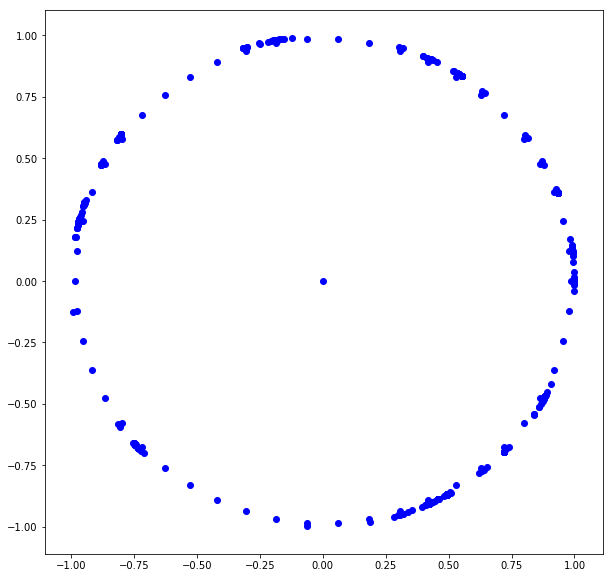

In [18]:
import matplotlib.pyplot as plt

e = embs['stanford']

plt.figure(figsize=(10, 10))

for k in e:
    plt.scatter(x = e[k][0], y = e[k][1], c='b')
plt.savefig('./im/Poincare_embedding')

In [19]:
with open('/datahdd/vmanuel/hyperbolic_embedding_algorithms/HyperE-Stanford/hyperbolics/distance_matrix.0', 'r') as inp:
#     li = inp.readlines()
    
    
    
#     li = [l.replace('\n', '') for l in li]
#     li = [l.split(',') for l in li]
    p = pd.read_table(inp, index_col = 0, header = 0, sep = ',', lineterminator='\n')

/home/vmanuel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [21]:
def get_pd_dist(node1, node2):
    return p[str(dic[node1])][dic[node2]]

In [22]:
true_edges_dist['pd'] = []
non_edges_dist['pd'] = []

for i, edge in enumerate(all_possible_edges):
    if edge in dbpedia_edges:
        true_edges_dist['pd'].append(get_pd_dist(edge[0], edge[1]))
    else:
        non_edges_dist['pd'].append(get_pd_dist(edge[0], edge[1]))
    if i % 10000 == 0:
        clear_output()
        print('{} / {}'.format(i, len(all_possible_edges)))
clear_output()
print('Done.')

Done.


In [38]:
quantiles = [0.25, 0.5, 0.7, 0.9, 0.99, 1]

# hyper_emb = embs[m]
for q in quantiles:
    false_pos = 0
    rec_edge_list = []
    quantile = np.quantile(true_edges_dist['pd'], q)
    for i, edge in enumerate(all_possible_edges):
        dist = get_pd_dist(edge[0], edge[1])
        if dist < quantile:
            rec_edge_list.append([edge[0], edge[1]])
            if [edge[0], edge[1]] not in dbpedia_edges or [edge[0], edge[1]] not in dbpedia_edges:
                false_pos += 1
    print('{} Recall Level : {}, false positive : {}, false_positive_perc: {:>.4f}'.format('pd', q, false_pos, false_pos/len(rec_edge_list)))

pd Recall Level : 0.25, false positive : 11, false_positive_perc: 0.0651
pd Recall Level : 0.5, false positive : 14, false_positive_perc: 0.0654
pd Recall Level : 0.7, false positive : 79, false_positive_perc: 0.1511
pd Recall Level : 0.9, false positive : 90, false_positive_perc: 0.1306
pd Recall Level : 0.99, false positive : 92, false_positive_perc: 0.1220
pd Recall Level : 1, false positive : 201986, false_positive_perc: 0.9967


In [33]:
get_pd_dist(inv_dic[str(dic['Thing'])], inv_dic[str(dic['Mammal'])])

2.538871664754041

In [35]:
hyperbolic_distance(stanford_emb['Thing'], stanford_emb['Mammal'])

12.570083830190718

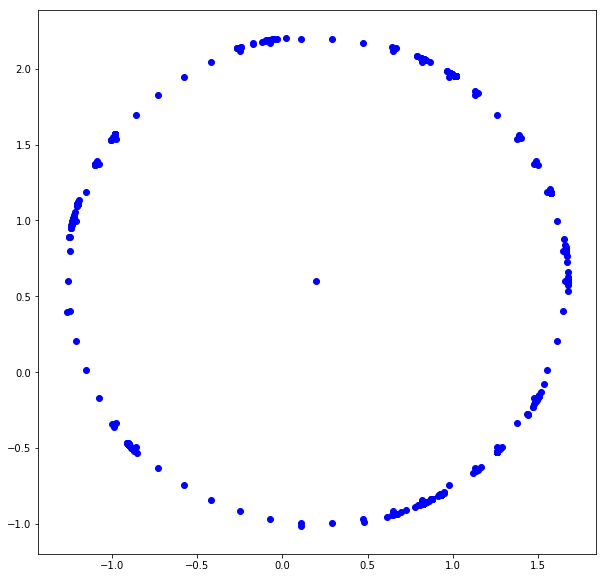

In [81]:
from sklearn.preprocessing import StandardScaler

e = embs['stanford']

xs = [v[0] for v in e.values()]
ys = [v[1] for v in e.values()]

xs = preprocessing.scale(xs)
ys = preprocessing.scale(ys)

plt.figure(figsize=(10,10))
for x, y in zip(xs, ys):
    plt.scatter(x,y, c ='b')
    
scaled_emb = [np.array([x, y]) for x, y in zip(xs, ys)]

In [84]:
for s in scaled_emb:
    print(s)

[0.20030355 0.60040338]
[1.65543451 0.60040338]
[1.64396037 0.80043793]
[1.60971889 0.99731782]
[1.5532501  1.18793814]
[1.47544453 1.36929268]
[1.37752922 1.53852138]
[1.26104837 1.69295539]
[1.12783893 1.83015921]
[0.98000171 1.94796904]
[0.81986818 2.04452696]
[0.64996375 2.11831018]
[0.4729679  2.16815511]
[0.29167198 2.19327566]
[0.10893513 2.19327566]
[-0.0723608   2.16815511]
[-0.24935664  2.11831018]
[-0.41926107  2.04452696]
[-0.5793946   1.94796904]
[-0.72723182  1.83015921]
[-0.86044126  1.69295539]
[-0.97692212  1.53852138]
[-1.07483742  1.36929268]
[-1.15264299  1.18793814]
[-1.20911179  0.99731782]
[-1.24335326  0.80043793]
[-1.2548274   0.60040338]
[-1.24335326  0.40036882]
[-1.20911179  0.20348893]
[-1.15264299  0.01286861]
[-1.07483742 -0.16848593]
[-0.97692212 -0.33771462]
[-0.86044126 -0.49214864]
[-0.72723182 -0.62935246]
[-0.5793946  -0.74716229]
[-0.41926107 -0.84372021]
[-0.24935664 -0.91750343]
[-0.0723608  -0.96734836]
[ 0.10893513 -0.99246891]
[ 0.29167198 -0.